# BBC Analysis - A6 Solution

This is a code solution for Assignment 6. It does **not** include all my observations or analysis, and is not fully written up as I expect an assignment submission.

## Setup

Support for locating text files to load:

In [1]:
from pathlib import Path

Import basic Pandas code:

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse as sps

Import the SciKit-Learn components we will need:

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, accuracy_score, make_scorer
from sklearn.manifold import TSNE

And initialize a random seed:

In [4]:
rng = np.random.RandomState(20201121)

## Load Data

In [5]:
articles = pd.DataFrame.from_records(
    ((f.parent.name, f.name, f.read_text('latin1')) for f in Path('bbc').glob('*/*.txt')),
    columns=['class', 'file', 'text']
)
articles.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   2225 non-null   object
 1   file    2225 non-null   object
 2   text    2225 non-null   object
dtypes: object(3)
memory usage: 5.2 MB


In [6]:
articles.head()

,class,file,text
0,business,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...
1,business,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...
2,business,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...
3,business,004.txt,High fuel prices hit BA's profits\n\nBritish A...
4,business,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...


Make a train-test pair:

In [7]:
test = articles.sample(frac=0.2, random_state=rng)
train_mask = pd.Series(True, index=articles.index)
train_mask[test.index] = False
train = articles[train_mask].copy()
train.head()

,class,file,text
0,business,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...
2,business,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...
3,business,004.txt,High fuel prices hit BA's profits\n\nBritish A...
4,business,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...
5,business,006.txt,Japan narrowly escapes recession\n\nJapan's ec...


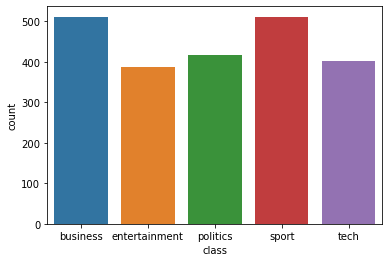

In [8]:
sns.countplot(articles['class'])

## Multinomial Naive Bayes

Train and evaluate a Naive Bayes classifier for the document category:

In [9]:
bayes = Pipeline([
    ('parse', CountVectorizer()),
    ('bayes-classify', MultinomialNB())
])
bayes.fit(train['text'], train['class'])

Pipeline(steps=[('parse', CountVectorizer()),
                ('bayes-classify', MultinomialNB())])

What is the train accuracy?

In [10]:
(bayes.predict(train['text']) == train['class']).mean()

0.9938202247191011

What is the test accuracy?

In [11]:
(bayes.predict(test['text']) == test['class']).mean()

0.9662921348314607

## k-NN

Now let's use k-NN over TF-IDF:

In [12]:
knn = Pipeline([
    ('parse', TfidfVectorizer(stop_words='english')),
    ('knn-classify', KNeighborsClassifier())
])
knn.fit(train['text'], train['class'])

Pipeline(steps=[('parse', TfidfVectorizer(stop_words='english')),
                ('knn-classify', KNeighborsClassifier())])

What is the train accuracy?

In [13]:
(knn.predict(train['text']) == train['class']).mean()

0.9561797752808989

What is the test accuracy?

In [14]:
(knn.predict(test['text']) == test['class']).mean()

0.9325842696629213

Now let's search for a good neighborhood size with cross-validation:

In [15]:
knncv = Pipeline([
    ('parse', TfidfVectorizer(stop_words='english')),
    ('cvclass', GridSearchCV(KNeighborsClassifier(), {
        'n_neighbors': [1, 2, 3, 5, 7, 10]
    }, scoring=make_scorer(accuracy_score)))
])
knncv.fit(train['text'], train['class'])

Pipeline(steps=[('parse', TfidfVectorizer(stop_words='english')),
                ('cvclass',
                 GridSearchCV(estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 5, 7, 10]},
                              scoring=make_scorer(accuracy_score)))])

And measure its test accuracy:

In [16]:
accuracy_score(test['class'], knncv.predict(test['text']))

0.9280898876404494

## Matrix Factorization

Now we're going to use matrix factorization to first explore the data, and then as the basis for a k-NN classifier.

### SVD Exploration

In [17]:
svd = Pipeline([
    ('parse', TfidfVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(8, random_state=rng))
])
train_mf = svd.fit_transform(train['text'])
train_mf

array([[ 0.15148571, -0.08065126,  0.09365875, ...,  0.0213691 ,
        -0.01676427,  0.01422109],
       [ 0.10721371, -0.00047994,  0.05430269, ...,  0.27481915,
         0.33895507, -0.09037746],
       [ 0.13299856, -0.03747084,  0.0631131 , ..., -0.01265649,
        -0.00644728,  0.01002857],
       ...,
       [ 0.14345714, -0.06406789,  0.16131461, ...,  0.15725728,
        -0.24443627, -0.00863497],
       [ 0.1873174 , -0.03018214,  0.08807297, ...,  0.19156927,
        -0.07439913,  0.03369349],
       [ 0.11595201,  0.00059895,  0.06450892, ...,  0.08102472,
        -0.10539635, -0.01667507]])

In [18]:
train_df = pd.DataFrame(train_mf, index=train.index)
train_df['class'] = train['class']

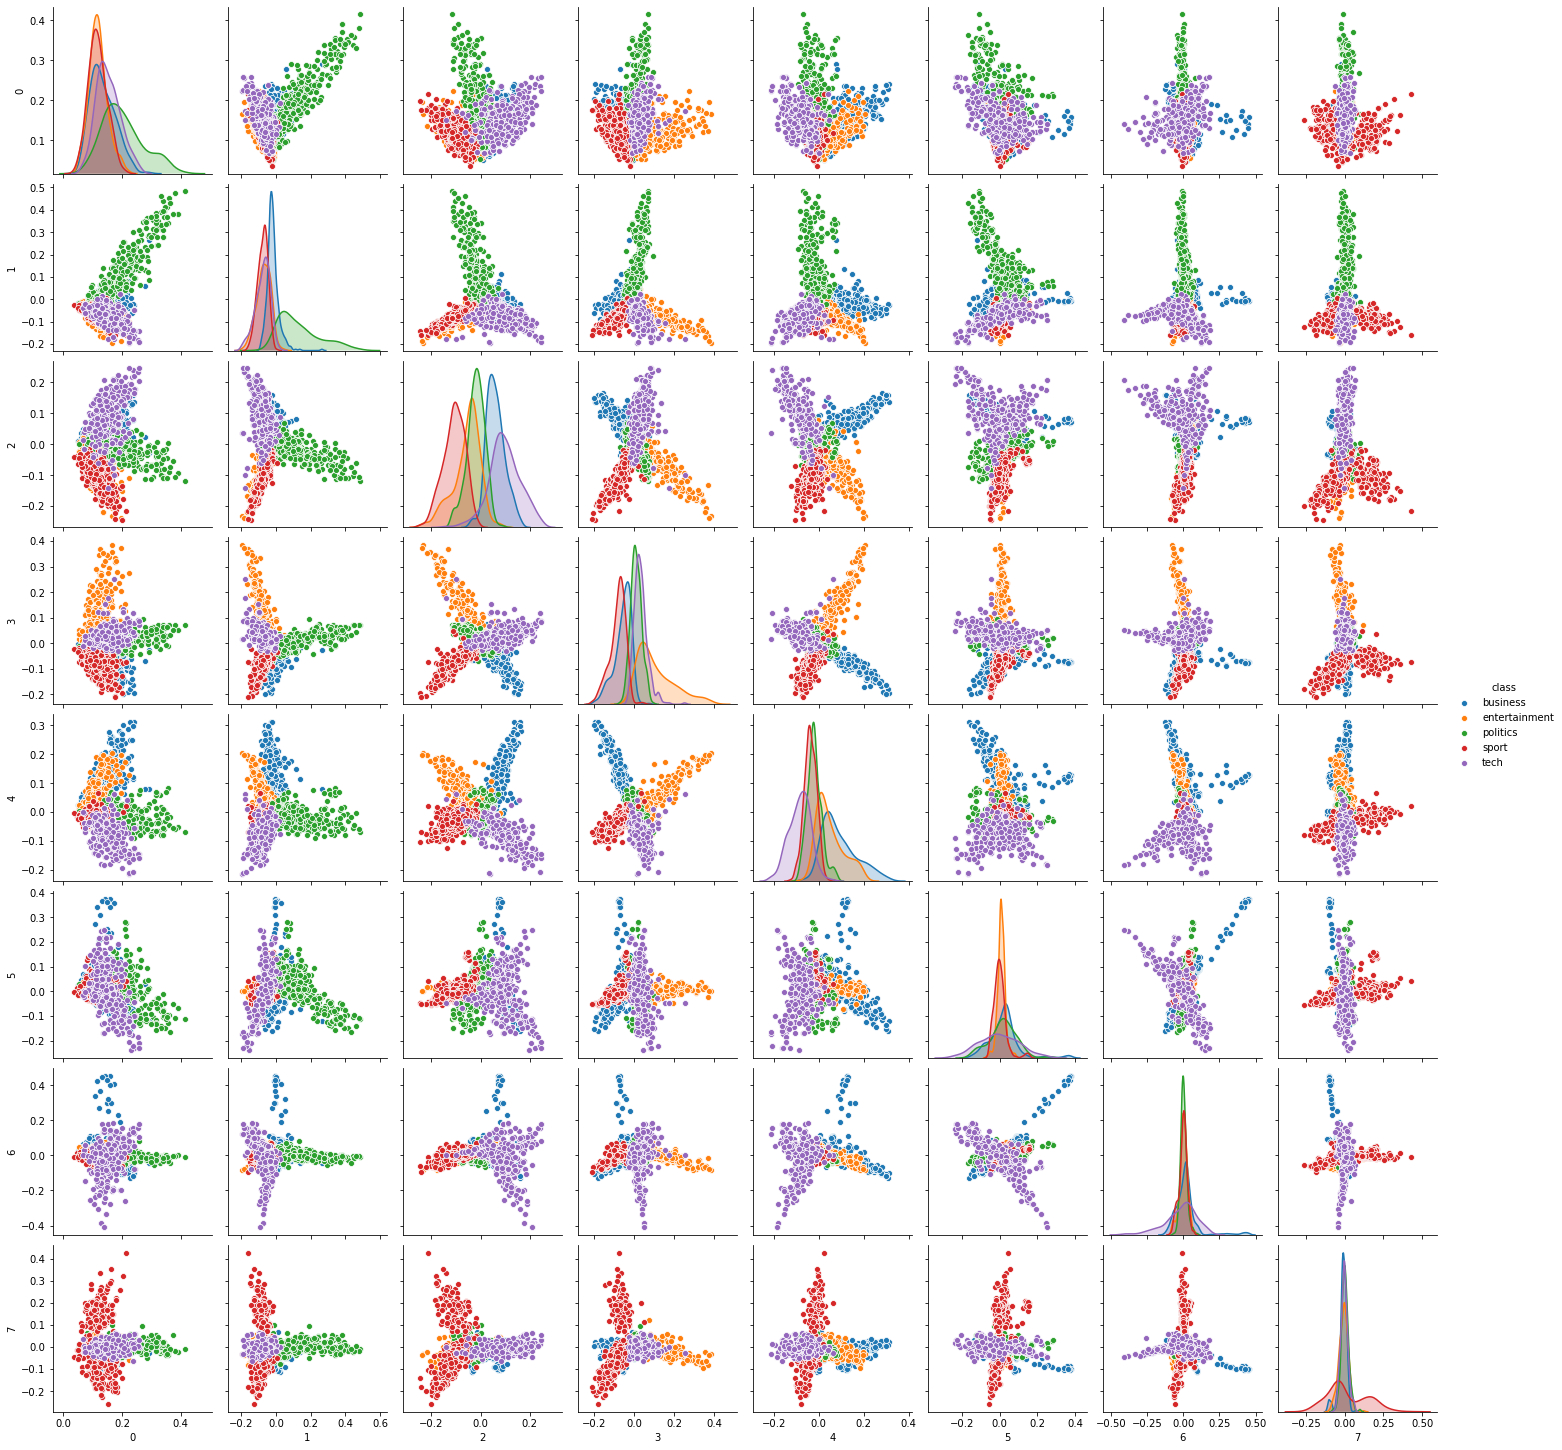

In [19]:
sns.pairplot(train_df, hue='class')

In [20]:
train_df.head()

,0,1,2,3,4,5,6,7,class
0,0.151486,-0.080651,0.093659,-0.018712,0.086161,0.021369,-0.016764,0.014221,business
2,0.107214,-0.000480,0.054303,-0.049278,0.087447,0.274819,0.338955,-0.090377,business
3,0.132999,-0.037471,0.063113,-0.066053,0.106398,-0.012656,-0.006447,0.010029,business
4,0.062331,-0.020216,0.022564,-0.024357,0.029374,0.025890,0.014527,-0.018207,business
5,0.128063,-0.030904,0.097553,-0.099735,0.163712,-0.084684,-0.063064,-0.000600,business


And get the top words for the first component:

In [21]:
np.array(svd.named_steps['parse'].get_feature_names())[np.argsort(-svd.named_steps['svd'].components_[0, :])[:5]]

array(['said', 'mr', 'labour', 'people', 'election'], dtype='<U31')

### SVD k-NN

Now we will try to use the SVD transformation as a basis for classifying articles.

In [22]:
svd_knn = Pipeline([
    ('parse', TfidfVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(8, random_state=rng)),
    ('knn-classify', KNeighborsClassifier(5))
])
svd_knn.fit(train['text'], train['class'])

Pipeline(steps=[('parse', TfidfVectorizer(stop_words='english')),
                ('svd',
                 TruncatedSVD(n_components=8,
                              random_state=RandomState(MT19937) at 0x2634EFB7C40)),
                ('knn-classify', KNeighborsClassifier())])

What is the train accuracy?

In [23]:
(svd_knn.predict(train['text']) == train['class']).mean()

0.9668539325842697

What is the test accuracy?

In [24]:
(svd_knn.predict(test['text']) == test['class']).mean()

0.9573033707865168

## Accuracy Summary

Now we should summarize our accuracies.  Compute training accuracy:

In [25]:
train_res = pd.DataFrame({
    'NB': bayes.predict(train['text']),
    'kNN': knn.predict(train['text']),
    'kNN-CV': knncv.predict(train['text']),
    'kNN-SVD': svd_knn.predict(train['text'])
})
train_acc = train_res.apply(lambda s: accuracy_score(train['class'], s))
train_acc

NB         0.993820
kNN        0.956180
kNN-CV     0.961798
kNN-SVD    0.966854
dtype: float64

And test accuracy:

In [26]:
test_res = pd.DataFrame({
    'NB': bayes.predict(test['text']),
    'kNN': knn.predict(test['text']),
    'kNN-CV': knncv.predict(test['text']),
    'kNN-SVD': svd_knn.predict(test['text'])
})
test_acc = test_res.apply(lambda s: accuracy_score(test['class'], s))
test_acc

NB         0.966292
kNN        0.932584
kNN-CV     0.928090
kNN-SVD    0.957303
dtype: float64

And combine them:

In [27]:
all_acc = pd.concat({
    'Train': train_acc,
    'Test': test_acc
}, names=['Set', 'Algorithm']).reset_index(name='Accuracy')
all_acc

,Set,Algorithm,Accuracy
0,Train,NB,0.993820
1,Train,kNN,0.956180
2,Train,kNN-CV,0.961798
3,Train,kNN-SVD,0.966854
4,Test,NB,0.966292
5,Test,kNN,0.932584
6,Test,kNN-CV,0.928090
7,Test,kNN-SVD,0.957303


Plot these together:

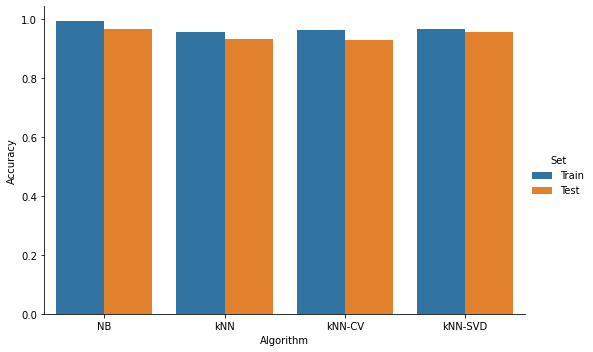

In [28]:
sns.catplot('Algorithm', 'Accuracy', hue='Set', data=all_acc, kind='bar', aspect=1.5)

## Clustering

Now we're going to use K-means clustering to cluster the articles:

In [29]:
raw_km = Pipeline([
    ('parse', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('cluster', KMeans(5, random_state=rng))
])
raw_km.fit(train['text'])

Pipeline(steps=[('parse',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('cluster',
                 KMeans(n_clusters=5,
                        random_state=RandomState(MT19937) at 0x2634EFB7C40))])

Now let's plot the class/cluster distribution:

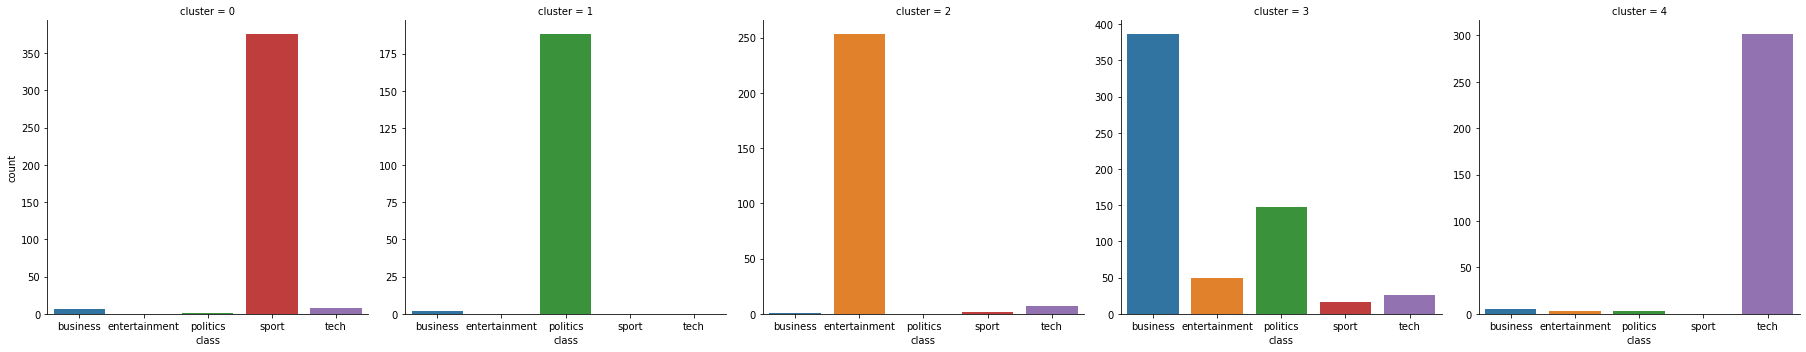

In [30]:
train_cl = pd.DataFrame({
    'class': train['class'],
    'cluster': raw_km.named_steps['cluster'].labels_
})
sns.catplot('class', col='cluster', data=train_cl, kind='count', sharey=False)

Now we want to get the cluster centers, to find the most important words for clusters.

In [31]:
clusters = pd.DataFrame(raw_km.named_steps['cluster'].cluster_centers_.T,
                        index=raw_km.named_steps['parse'].get_feature_names())
clusters.head()

,0,1,2,3,4
000,0.003341,0.013508,0.009758,0.015950,0.011027
000m,0.006894,0.000000,0.000000,0.000000,0.000000
05,0.000364,0.000445,0.001208,0.000357,0.000000
10,0.007629,0.007468,0.011008,0.007451,0.008024
100,0.001755,0.003597,0.002757,0.004578,0.005893


In [32]:
clusters.nlargest(5, 0)

,0,1,2,3,4
game,0.039819,0.000844,0.006018,0.000660,0.016949
england,0.034947,0.003140,0.001768,0.005180,0.000082
win,0.033226,0.007842,0.008983,0.001017,0.001185
said,0.029976,0.070608,0.029532,0.054083,0.044258
club,0.029772,0.000564,0.000939,0.002385,0.000268


In [33]:
clusters.nlargest(5, 1)

,0,1,2,3,4
mr,0.003016,0.123422,0.009806,0.028975,0.023960
labour,0.000000,0.110016,0.000523,0.004464,0.000149
election,0.000115,0.099593,0.000000,0.003392,0.001317
blair,0.000878,0.086735,0.000553,0.003514,0.000110
party,0.000000,0.084377,0.001836,0.002276,0.001916


In [34]:
clusters.nlargest(5, 2)

,0,1,2,3,4
film,0.000349,0.000867,0.107527,0.000472,0.005928
best,0.013615,0.004559,0.059372,0.003342,0.002049
awards,0.000874,0.000200,0.045715,0.000000,0.000851
award,0.001801,0.000189,0.038311,0.000225,0.001705
band,0.000155,0.000266,0.034885,0.000452,0.000647


In [35]:
clusters.nlargest(5, 3)

,0,1,2,3,4
said,0.029976,0.070608,0.029532,0.054083,0.044258
mr,0.003016,0.123422,0.009806,0.028975,0.023960
government,0.000246,0.042275,0.000528,0.025487,0.003683
year,0.022657,0.009675,0.030926,0.025477,0.014331
growth,0.000000,0.001537,0.000000,0.024636,0.004563


In [36]:
clusters.nlargest(5, 4)

,0,1,2,3,4
people,0.005156,0.032568,0.011294,0.013305,0.047352
said,0.029976,0.070608,0.029532,0.054083,0.044258
mobile,0.000000,0.000628,0.000577,0.002494,0.044162
technology,0.000497,0.000595,0.000466,0.002677,0.038254
users,0.000000,0.000000,0.000140,0.000745,0.036912


### 6 clusters

In [34]:
km6 = Pipeline([
    ('parse', TfidfVectorizer(stop_words='english')),
    ('cluster', KMeans(6, random_state=rng))
])
km6.fit(train['text'])

Pipeline(steps=[('parse', TfidfVectorizer(stop_words='english')),
                ('cluster',
                 KMeans(n_clusters=6,
                        random_state=RandomState(MT19937) at 0x2634EFB7C40))])

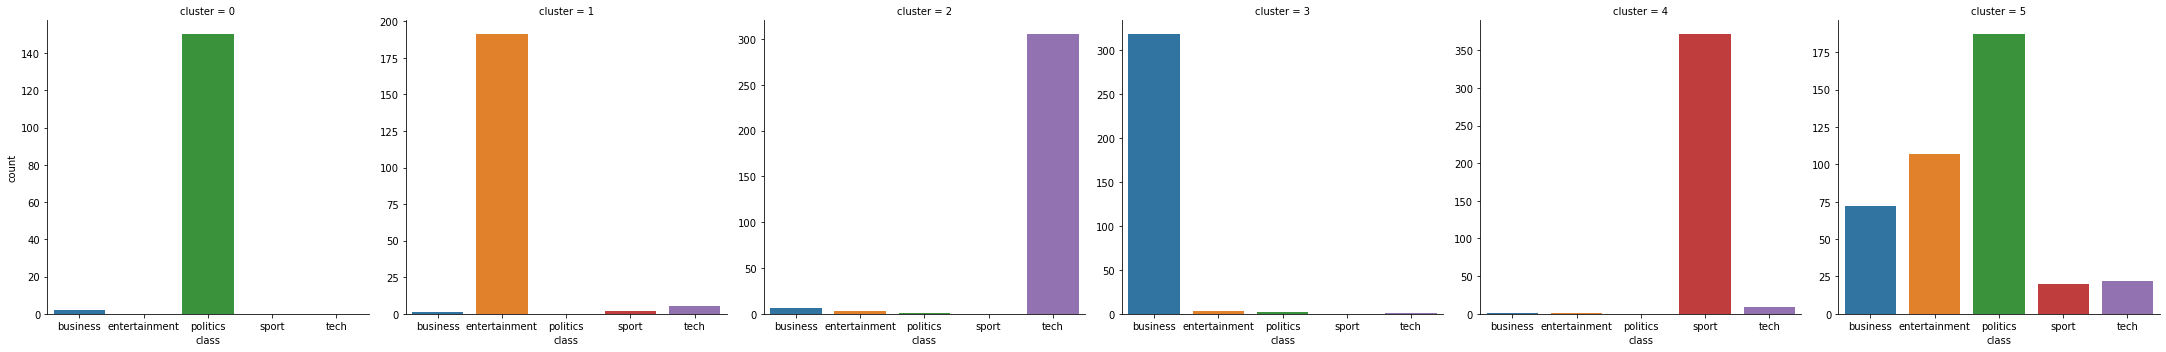

In [35]:
train_cl = pd.DataFrame({
    'class': train['class'],
    'cluster': km6.named_steps['cluster'].labels_
})
sns.catplot('class', col='cluster', data=train_cl, kind='count', sharey=False)

## t-SNE of data

This might help us understand the clusterings better.

In [36]:
sne_embed = Pipeline([
    # recommended by TNSE docs
    ('svd', TruncatedSVD(50, random_state=rng)),
    ('t-sne', TSNE(random_state=rng))
])
sne_parse = TfidfVectorizer(stop_words='english')
train_mat = sne_parse.fit_transform(train['text'])

Now we're going to embed both the documents *and* the cluster centers.  We have to do this all at once, because TSNE does not support `transform`, only `fit_transform`.  We have so few cluster centers w.r.t. number of documents it shouldn't break much.

I separated out parsing from embedding, so I can parse the text, and the combine the text with cluster centers into one large matrix to embed with t-SNE.  Let's do that now:

In [37]:
tc_mat = sps.vstack([train_mat, km6.named_steps['cluster'].cluster_centers_])
tc_sne = sne_embed.fit_transform(tc_mat)

Now we're going to pull out all but the last 6 rows (our cluster centers), and make a data frame with classes:

In [38]:
train_sne = pd.DataFrame(tc_sne[:-6, :], columns=['SNE0', 'SNE1'], index=train.index)
train_sne['class'] = train['class']

And plot, along with those last 6 rows (the cluster centers) as black + signs:

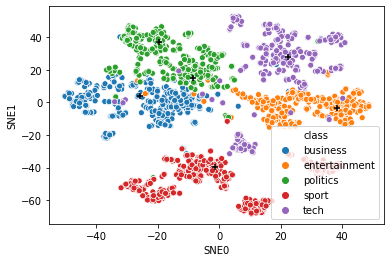

In [39]:
sns.scatterplot('SNE0', 'SNE1', hue='class', data=train_sne)
plt.scatter(tc_sne[-6:, 0], tc_sne[-6:, 1], color='black', marker='+')
plt.show()